# Instrumentacion y control: Practica 1 - Placa de audio #

## Introducción ## 
En este notebook vamos a implementar y registrar mediciones utilizando una placa de sonido. 

Para eso utilizamos el paquete soundDevice y desarrollamos codigo propio de manera de adaptar las funcionalidades que ofrece dicho paquete. El objetivo es tener montado sobre las funcionalidades de python y soundDevice una API que permita usar en forma rapida e intuitiva la placa de sonido para interactuar con dispotivos electronicos, usando el speaker como salida y el mic como entrada.

## Funcionalidades buscadas ##

- Generar señales periodicas tipicas (sinusoidal, triangular, cuadrada, etc)
- Registrar respuestas del sistema conectado frente a estimulos.
- Testear y autocaracterizar el sistema de la placa de sonido (ya que puede cambiar de computadora en computadora) 
- Conocer desfazaje entre estimulo enviado y respuesta detectada. 

## Materiales y Diseño experimental basico ## 

Para hacer funcionar el sistema se necesita una computadora o dispositivo que cuente con una salida de audio y una entrada fisicamente independiente de microfono. Ademas se necesita dos conectores Jack Mini Plug de 3.5mm (o la que corresponda al hardware donde se ejecute el codigo) stereo que terminen en cables sueltos. En nuestro caso para realizar todas las prueba experimentales conectamos dicho terminales a un protoboard. 

![setup inicial](Files/Imagenes/Setup1.jpeg)
![setup inicial](Files/Imagenes/Setup2.jpeg)

## Desarrollo de sofware ##

El codigo desarrollado esta incluido en el archivo AudioControl.py en forma de funciones de manera tal que se pueda importar el archivo y utilizarlas en forma directa. 
Describimos brevemente las funciones utiles:



# Mediciones y testeos #

El primer test a realizar es que el programa tenga acceso a la placa. Para eso debemos conectar el parlante usual a la salida de audio y ejecutar:

In [1]:
import AudioControl

In [2]:
# testeamos la salida conectado a parlantes

In [3]:
AudioControl.testOutput()

Tendría que haber escuchado 1 segundo de audio en cada canal


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:59<00:00,  1.14s/it]


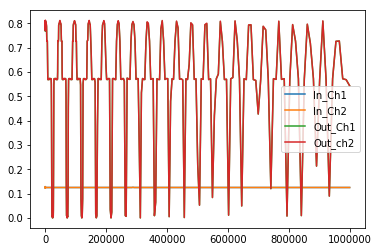

In [2]:
# Hacemos un barrido en frecuencias. Para chequear que todo funcione bien, primero lo hacemos con un cable comprado que tiene dos miniplug donde conectamos una la salida y otro a la entrada. 
%matplotlib inline
%load_ext autoreload
Frecs, In, Out = AudioControl.RtaFrecuencia()

In [6]:
# Almacenamos los datos
import numpy as np
np.savetxt ('./Resultados/RtaFrecCableBuenoFrecs.txt',Frecs,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCableBuenoIn.txt',In,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCableBuenoOut.txt',Out,delimiter=',')


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:52<00:00,  1.12s/it]


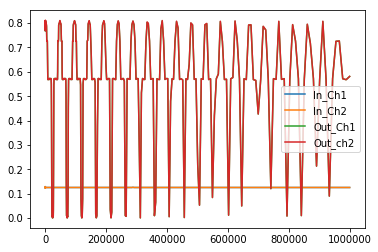

In [7]:
# Repetimos la medicion con los cables y el protoboard armados y conectados (esperamos la misma respuesta que antes salvo que el protoboarod o los cables traigan complicaciones.)
# NOTA: Uno de los plug tiene mucho problema para conectar bien, tuvimos que probar mucho (haciendo un play rec sencillo) hasta encontrar la posicion en que hace contacto a traves de los dos canales. 
# Suponemos que es una cuestion de la forma del macho o hembra que no acoplan bien. 
FrecsBis, InBis, OutBis = AudioControl.RtaFrecuencia()